#  Прогнозирование заказов такси

**Описание проекта:** таксомоторная компания хочет знать количество заказов такси на следующий час, чтобы привлекать больше водителей в периоды пиковой нагрузки. 

**Цель проекта:** спрогнозировать количество заказов такси в час на заданный интервал. Значение метрики `RMSE` на тестовой выборке должно быть не более `48`.

**Используемые данные:** исторические данные о заказах такси в аэропортах. Размерность признака `num_orders` — количество заказов такси в час. 

## Оглавление
1. [Подготовка](#1)
2. [Анализ](#2)
3. [Обучение](#3)
4. [Тестирование](#4)

<a id="1"></a>
## 1. Подготовка
Импортируем необходимые библиотеки.

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import warnings


warnings.filterwarnings("ignore")

Считаем файл с данными, установим дату и время как индекс и выведем данные на экран.

In [2]:
data = pd.read_csv("/datasets/taxi.csv", index_col="datetime")
data.index = pd.DatetimeIndex(data.index)
data.sort_index(inplace=True)

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведём ресемплирование данных по одному часу.

In [3]:
data = data.resample('1H').sum()

<a id="2"></a>
## 2. Анализ
Построим гистограмму распределения количества заказов в час. 

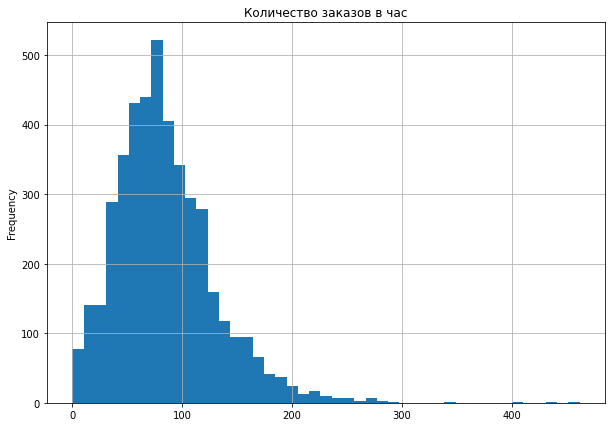

In [4]:
data["num_orders"].plot(kind="hist", bins=45, 
                        title="Количество заказов в час", 
                        grid=True,
                        figsize=(10, 7));

Есть несколько выделяющихся значений (больше трёхсот заказов в час), но их мало и они не выглядят аномальными, поэтому дополнительная обработка не требуется.

Разложим ряд на тренд, сезонную составляющую и остатки и выведем графики для каждого компонента.

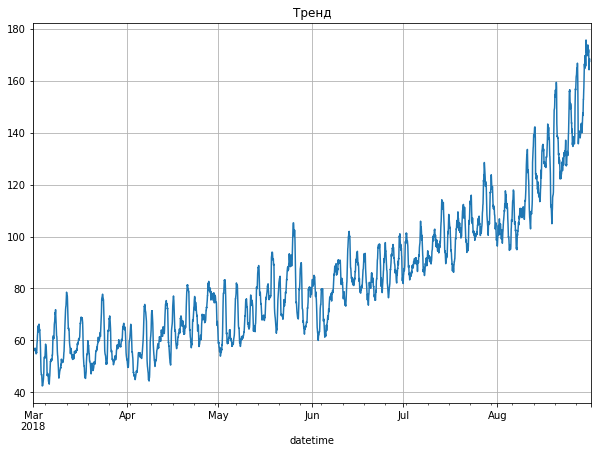

In [5]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(grid=True, title="Тренд", figsize=(10, 7));

К осени количество заказов в час увеличивается, однако нельзя сделать достоверный вывод относительно причин этого увеличения.

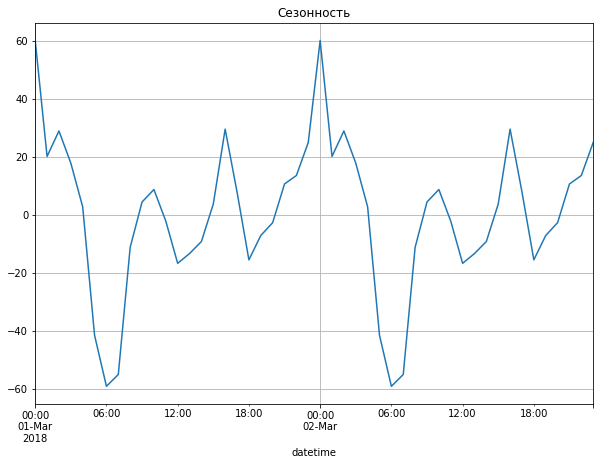

In [6]:
decomposed.seasonal["2018-03-01": "2018-03-02"].plot(grid=True, title="Сезонность", figsize=(10, 7));

Можно заметить цикличность. Максимум приходится на полночь, а минимум — на шесть часов утра.

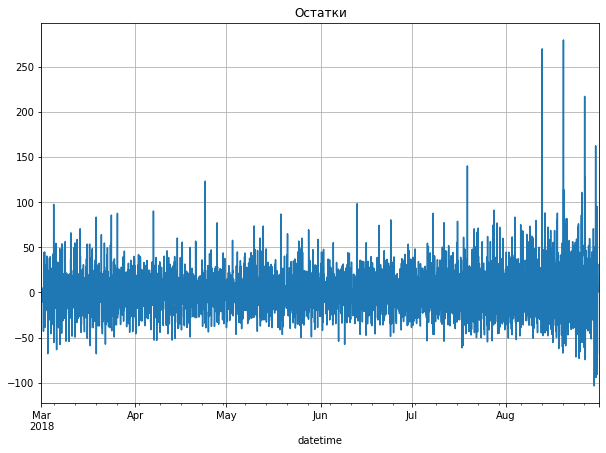

In [7]:
decomposed.resid.plot(grid=True, title="Остатки", figsize=(10, 7));

Остатки — это просто случайный шум. 

Напишем функцию для создания признаков на основе `num_orders`.

In [8]:
def make_features(df, max_lag, rolling_mean_size, inplace=False):
    if not inplace:
        df_new = df.copy(deep=True)
        df = df_new
    
    df["month"] = df.index.month
    df["dayofweek"] = df.index.dayofweek
    df["day"] = df.index.day
    df["hour"] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df[f"lag_{lag}"] = df["num_orders"].shift(lag)

    df["rolling_mean"] = df["num_orders"].shift().rolling(rolling_mean_size).mean()
    
    if not inplace:
        return df
    
    return

Применим эту функцию с некоторыми параметрами (эмпирически подобранными) `max_lag` (максимальный лаг) и `rolling_mean_size` (размер скользящего окна). Кроме того, используем OHE для кодирования категориальных признаков, таких как `month`, `day`, `dayofweek` и `hour` (месяц, день, день недели и час). Разделим данные на обучающую и тестовую выборки, не нарушая их порядок. Для проведения скользящего контроля создадим объект `TimeSeriesSplit`.

In [9]:
data = make_features(data, 24, 7)

data = pd.get_dummies(data, columns=["dayofweek", "month", "hour", "day"], drop_first=True)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train, y_train = train.drop(columns="num_orders"), train["num_orders"]
X_test, y_test = test.drop(columns="num_orders"), test["num_orders"]

tscv = TimeSeriesSplit(n_splits=3)

<a id="3"></a>
## 3. Обучение
Для удобства напишем функцию, которая будет подбирать гиперпараметры и возвращать значение `RMSE` для лучшей модели на перекрёстной проверке и саму модель.

In [10]:
def grid_search_cv(model, 
                   param_grid, 
                   X_train, y_train, 
                   cv, 
                   scoring="neg_root_mean_squared_error"):
    
    grid = GridSearchCV(model, 
                        param_grid=param_grid,
                        scoring=scoring,
                        cv=cv)

    grid.fit(X_train, y_train)
    return -grid.best_score_, grid.best_estimator_

Зададим сетки гиперпараметров.

In [11]:
param_grid_for_ridge = {
    "alpha": [10**i for i in range(-4, 4)]
}

param_grid_for_lasso = {
    "alpha": [10**i for i in range(-4, 4)]
}

param_grid_for_gbr = {
    "n_estimators": [30, 50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": range(3, 8)
}

Проведём обучение разных моделей и подбор гиперпараметров.

In [12]:
models = {
    "Ridge": (Ridge(random_state=42), param_grid_for_ridge),
    "Lasso": (Lasso(random_state=42), param_grid_for_lasso),
    "GradientBoostingRegressor": (GradientBoostingRegressor(random_state=42), param_grid_for_gbr)
}

results = {}
best_models = {}

for model_name, model in models.items():
    results[model_name], best_models[model_name] = grid_search_cv(model[0], model[1], X_train, y_train, cv=tscv)
    print(f"Cross validation for {model_name}: OK")

Cross validation for Ridge: OK
Cross validation for Lasso: OK
Cross validation for GradientBoostingRegressor: OK


In [13]:
results = pd.DataFrame(results.values(), index=results.keys(), columns=["RMSE"])

Результаты приведены в таблице ниже.

In [14]:
results

,RMSE
Ridge,27.395189
Lasso,26.837427
GradientBoostingRegressor,26.457327


In [15]:
print(f'Лучшая модель: {results["RMSE"].idxmin()}')

Лучшая модель: GradientBoostingRegressor


Выбрав лучшую модель, проверим её на тестовой выборке.

<a id="4"></a>
## 4. Тестирование

In [16]:
model = best_models[results["RMSE"].idxmin()]
y_pred = model.predict(X_test)
rmse_gbr = mean_squared_error(y_test, y_pred, squared=False)

print(f"RMSE для GradientBoostingRegressor на тестовой выборке: {rmse_gbr:.3f}")

RMSE для GradientBoostingRegressor на тестовой выборке: 43.257


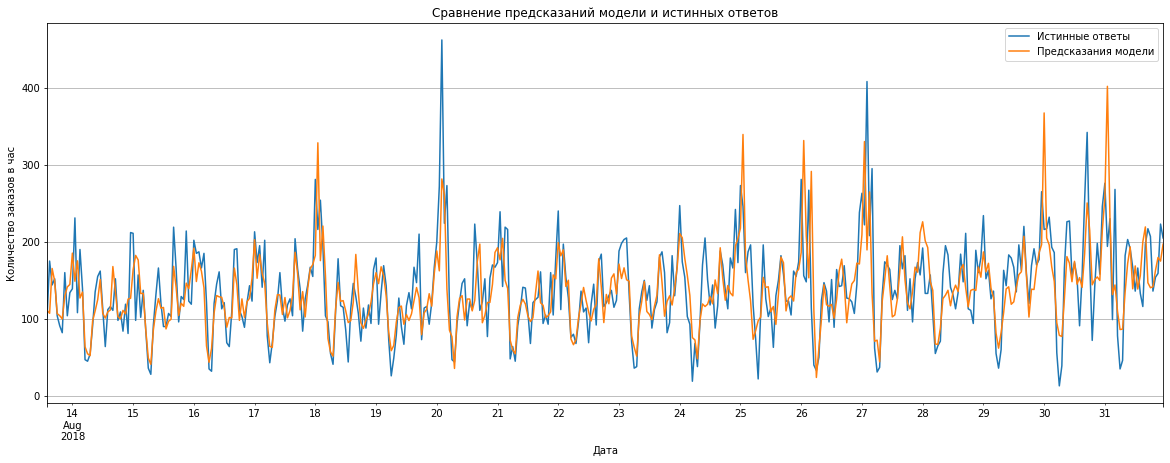

In [19]:
y_pred = pd.Series(y_pred, index=y_test.index, name="Предсказания модели")
y_test.name = "Истинные ответы"

pd.DataFrame(y_test).join(y_pred).plot(grid=True, figsize=(20, 7), 
                                       title="Сравнение предсказаний модели и истинных ответов",
                                       ylabel="Количество заказов в час",
                                       xlabel="Дата");

Полученное значение `RMSE` на тестовой выборке составляет `43.257`, цель проекта достигнута. 

Форма графиков выглядит примерно одинаковой, модель относительно хорошо справляется с предсказаниями значений, лежащих в интервале от 50 до 200 заказов в час. Однако модель допускает ошибки на экстремальных значениях (например, около полуночи 20-го и 27-го августа). 